## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language models (for decoder and encoder)

* or just fine-tunning BART/ELECTRA/... ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_to_data = 'data.txt'
if not os.path.exists(path_to_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_to_data = './data.txt'

Baseline solution BLEU score is quite low. Try to achieve at least __21__ BLEU on the test set. 
The checkpoints are:

* __21__ - minimal score to submit the homework, 30% of points

* __25__ - good score, 70% of points

* __27__ - excellent score, 100% of points

### Warning! The code below is deeeeeeeply deprecated and is is provided only as simple guide.
We suggest you to stick to most recent pipelines here, e.g. by Huggingface: 
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

In [3]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import random
import math
import time
import tqdm
import importlib

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import numpy as np

from nltk.translate.bleu_score import corpus_bleu
from nltk.tokenize import WordPunctTokenizer

from utils import epoch_time
from utils import get_text
from utils import generate_translation

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
SEED = 0

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [6]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [7]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower=True,
            include_lengths=True)

# SRC = Field(tokenize=tokenize,
#             init_token = '<sos>', 
#             eos_token = '<eos>', 
#             lower=True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower=True)

dataset = torchtext.data.TabularDataset(
    path=path_to_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [8]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [9]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [10]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [11]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 14009
Unique tokens in target (en) vocabulary: 10117


Here are tokens from original (RU) corpus:

In [12]:
SRC.vocab.itos[::1000]

['<unk>',
 'беспроводной',
 'шереметьево',
 'копировальные',
 'george',
 'шота',
 'long',
 'фе',
 'дубровнике',
 'технологий',
 'meridien',
 'виндзора',
 'лотос',
 'революции',
 'ярославля']

And from target (EN) corpus:

In [13]:
TRG.vocab.itos[::1000]

['<unk>',
 'sites',
 'den',
 'colorful',
 'nairobi',
 'speedway',
 'masseria',
 'balíon',
 'haapsalu',
 'pelion',
 'warner']

And here is example from train dataset:

In [14]:
print(vars(train_data.examples[9]))

{'trg': ['the', 'area', 'is', 'popular', 'for', 'skiing', 'and', 'golfing', '.'], 'src': ['в', 'окружающем', 'районе', 'популярны', 'лыжный', 'спорт', 'и', 'гольф', '.']}


Let's check the length distributions:

Length distribution in Train data


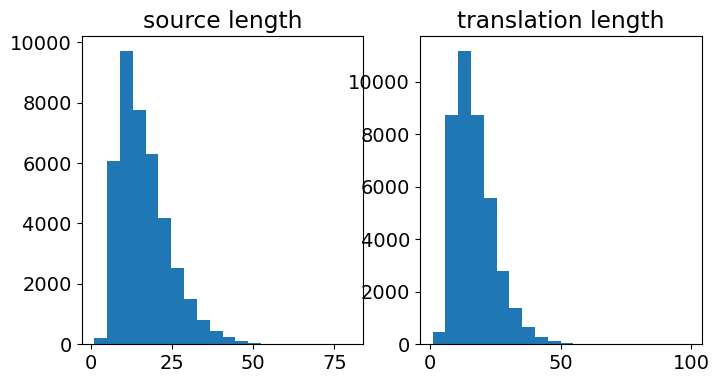

In [15]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


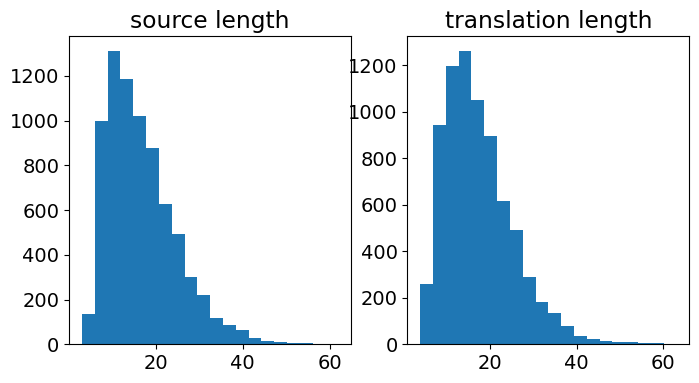

In [16]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

In [17]:
src_length = list(map(len, [vars(x)['src'] for x in train_data.examples])) + list(map(len, [vars(x)['src'] for x in test_data.examples]))
trg_length = list(map(len, [vars(x)['trg'] for x in train_data.examples])) + list(map(len, [vars(x)['trg'] for x in test_data.examples]))
print("Max length SRC sentence =", max(src_length))
print("Max length TRG sentence =", max(trg_length))

Max length SRC sentence = 80
Max length TRG sentence = 99


### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [18]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [19]:
for x in train_iterator:
    break
print(x)
print(x.src[0].shape, x.trg.shape)


[torchtext.data.batch.Batch of size 32]
	[.trg]:[torch.cuda.LongTensor of size 48x32 (GPU 0)]
	[.src]:('[torch.cuda.LongTensor of size 47x32 (GPU 0)]', '[torch.cuda.LongTensor of size 32 (GPU 0)]')
torch.Size([47, 32]) torch.Size([48, 32])


### Simple Seq2Seq

Simple three layers encoder-decoder network

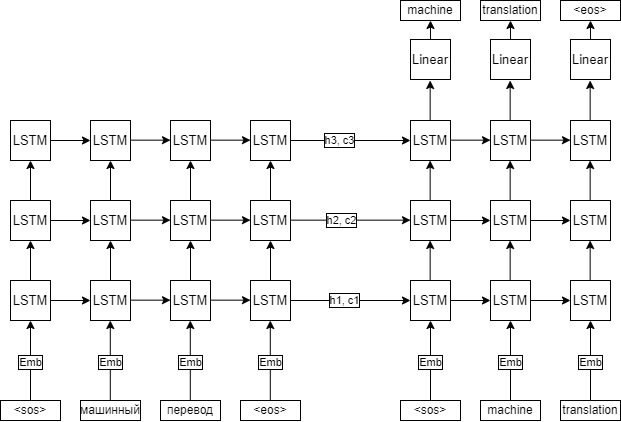

In [20]:
import seq2seq_base
importlib.reload(seq2seq_base)

<module 'seq2seq_base' from 'C:\\Users\\timmy_maks\\Advanced ML\\Lab02_NMT\\seq2seq_base.py'>

In [21]:
from seq2seq_base import Encoder
from seq2seq_base import Decoder
from seq2seq_base import Seq2Seq
from seq2seq_base import train
from seq2seq_base import evaluate

In [22]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
N_LAYERS = 3
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, DEC_HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [28]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
        
model.apply(init_weights)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 22,925,189 trainable parameters


Train src -> trg

In [29]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [42]:
train_history = []
valid_history = []

N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')

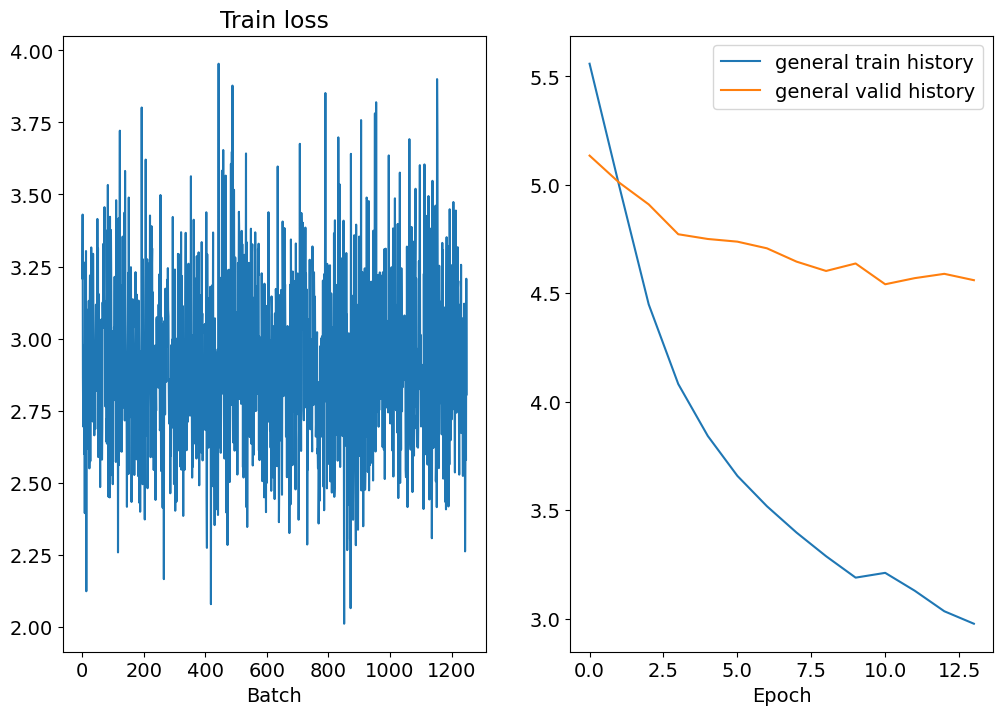

Epoch: 05 | Time: 5m 36s
	Train Loss: 2.917 | Train PPL:  18.477
	 Val. Loss: 4.592 |  Val. PPL:  98.723
Total time: 26.85 m


In [43]:
start_time_0 = time.time()
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'seq2seq_base.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

print(f"Total time: {int(time.time() - start_time_0) / 60} m")

Let's take a look at our network quality

Loading the model with the best loss on test

In [23]:
model.load_state_dict(torch.load('seq2seq_base.pt'))

<All keys matched successfully>

In [45]:
print(f"Best Valid Loss = {best_valid_loss:.3f}")

Best Valid Loss = 4.542


In [46]:
%%time
print(f"Test Loss = {evaluate(model, test_iterator, criterion)}")

Test Loss = 4.576461481540761
CPU times: total: 51.5 s
Wall time: 8.72 s


In [24]:
original_text = []
generated_text = []
source_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0)
        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

print(f"BLEU Score: {corpus_bleu([[text] for text in original_text], generated_text) * 100:.3f}")

235it [00:08, 26.14it/s]


BLEU Score: 13.299


In [26]:
batch = next(iter(test_iterator))

In [31]:
for idx in random.sample(range(32), 5):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab, SRC.vocab)

Source: предоставляется бесплатная парковка .
Original: the property offers free parking .
Generated: free parking is available .

Source: предоставляется бесплатный wifi .
Original: free wifi access is available .
Generated: free wifi access is available .

Source: предоставляются полотенца .
Original: towels are available .
Generated: towels .

Source: осуществляется обслуживание номеров .
Original: room service is provided .
Generated: a service .

Source: предоставляются услуги трансфера .
Original: a shuttle service can be arranged .
Generated: a service service .



### Attention Seq2Seq

The encoder consists of a bidirectional GRU (two layers). The encoder consists of a unidirectional GRU (single layer). The mechanism of attention is applied.
* GRU
* 2 layers bidirectional encoder
* Positional encoding
* Attention
* Сoncatenation of attention, input and decoder output before linear
* Learning rate decay

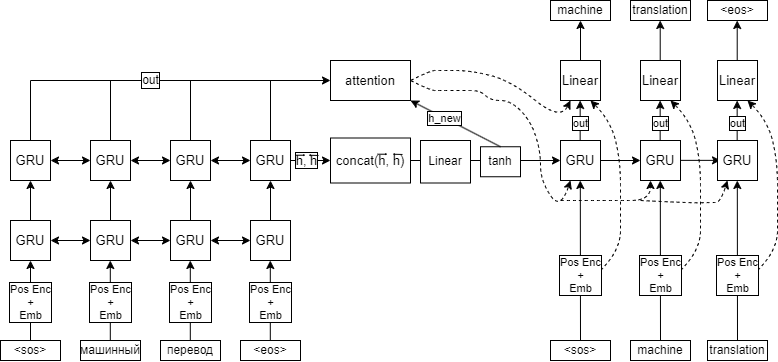

Importing the model

In [20]:
import seq2seq_gru
importlib.reload(seq2seq_gru)
from seq2seq_gru import Attention
from seq2seq_gru import Encoder
from seq2seq_gru import Decoder
from seq2seq_gru import Seq2Seq
from seq2seq_gru import train
from seq2seq_gru import evaluate

Initializing the model

In [21]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_NUM_LAYERS = 2
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
MAX_SEQ_LEN = 100

attention = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_NUM_LAYERS, ENC_DROPOUT, device, MAX_SEQ_LEN)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attention, device, MAX_SEQ_LEN)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

Setting up the initial weights

In [29]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
        
model.apply(init_weights)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 35,525,253 trainable parameters


In [30]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

Train part

In [28]:
train_history = []
valid_history = []

N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')

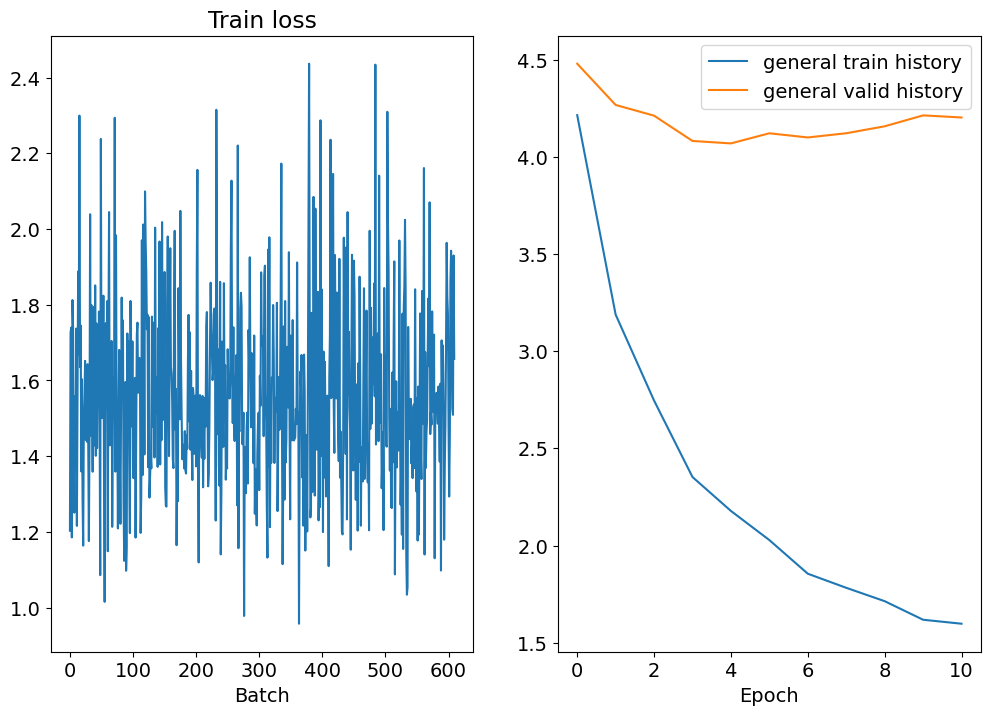

KeyboardInterrupt: 

In [29]:
start_time_0 = time.time()
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, scheduler, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'seq2seq_gru.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

print(f"Total time: {int(time.time() - start_time_0) / 60} m")

Let's take a look at our network quality

Loading the model with the best loss on test

In [22]:
model.load_state_dict(torch.load('seq2seq_gru.pt'))

<All keys matched successfully>

In [32]:
print(f"Test Loss = {evaluate(model, test_iterator, criterion):.3f}")

Test Loss = 4.107


In [33]:
original_text = []
generated_text = []
source_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src, src_len = batch.src
        trg = batch.trg

        output = model(src, src_len, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

print(f"BLEU Score: {corpus_bleu([[text] for text in original_text], generated_text) * 100:.3f}")

235it [00:23, 10.18it/s]


BLEU Score: 29.745


In [24]:
batch = next(iter(test_iterator))

In [33]:
for idx in random.sample(range(32), 5):
    src, src_len = batch.src
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src[:, idx:idx+1], trg, model, TRG.vocab, SRC.vocab, "src_len", src_len[idx:idx+1])

Source: предоставляется бесплатная парковка .
Original: the property offers free parking .
Generated: the property offers free parking .

Source: осуществляется доставка продуктов .
Original: the property also offers grocery delivery .
Generated: the property also offers grocery delivery .

Source: обустроена бесплатная парковка .
Original: free parking is available .
Generated: the property offers free parking .

Source: предоставляется бесплатная парковка .
Original: the property offers free parking .
Generated: the property offers free parking .

Source: открыт сувенирный магазин .
Original: you will find a gift shop at the property .
Generated: there is a gift shop at the property .



# Fine-tuning the model

Fine-tune model with our own dataset

Model Description:

* Developed by: Language Technology Research Group at the University of Helsinki
* Model Type: Transformer-align

Importing libs

In [6]:
import pandas as pd
import datasets
import evaluate
from transformers import AutoTokenizer
from datasets import load_dataset, load_metric
from transformers import DataCollatorForSeq2Seq
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import pipeline
from random import randrange
from sklearn.model_selection import train_test_split

Importing data

In [10]:
dataset = load_dataset("csv", data_files="train_valid.csv")

Found cached dataset csv (C:/Users/timmy_maks/.cache/huggingface/datasets/csv/default-38278c74016572b4/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
dataset_test = pd.read_csv("test.csv")

In [12]:
test_src = [sent for sent in dataset_test.ru]
test_trg = [sent for sent in dataset_test.en]

In [13]:
dataset = dataset["train"].map(lambda ex, 
                               i: {"id": i, "translation": dict(ex)}, 
                               remove_columns=["en", "ru"], 
                               features=datasets.Features({"id": datasets.Value("string"), 
                                                           "translation": datasets.Translation(languages=["en", "ru"])}),
                               with_indices=True,)


dataset = dataset.train_test_split(test_size=0.15)
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ru-en", device='cuda:0')
source_lang = "ru"
target_lang = "en"
prefix = "translate Russian to English: "

Loading cached processed dataset at C:\Users\timmy_maks\.cache\huggingface\datasets\csv\default-38278c74016572b4\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-a088e4d4ba070947.arrow


Preprocess function

In [14]:
def preprocess_function(examples):
    inputs = []
    targets = []
    for example in examples["translation"]:
        if example[source_lang] is not None and example[target_lang] is not None and \
        len(example[source_lang].strip()) > 3 and len(example[target_lang].strip()) > 3:
            inputs.append(prefix + example[source_lang].strip())
            targets.append(example[target_lang].strip())
        else:
            "There is an issue with this segment:"
            print("Source:", example[source_lang])
            print("Target:", example[target_lang])
            random_num = randrange(10000)
            print("Replaced with", random_num)
            inputs.append(prefix + str(random_num))
            targets.append(str(random_num))
    model_inputs = tokenizer(inputs, max_length=100, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=100, truncation=True)
        model_inputs["labels"] = labels["input_ids"]
    return model_inputs

Download pretrained model

In [15]:
tokenized = dataset.map(preprocess_function, batched=True)
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-ru-en")
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

Map:   0%|          | 0/40375 [00:00<?, ? examples/s]

D:\Anaconda\lib\site-packages\transformers\tokenization_utils_base.py:3546: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Source: .
Target: .
Replaced with 6311


Map:   0%|          | 0/7125 [00:00<?, ? examples/s]

Let's check BLEU before fine-tune

In [16]:
translator = pipeline("translation", model=model, tokenizer=tokenizer, device='cuda:0')
bleu = evaluate.load("bleu")

In [39]:
def calculate_bleu(model, src, trg, translator, bleu=bleu):
    pred_trg = translator(src)
    for i in range(len(pred_trg)):
        pred_trg[i] = pred_trg[i]["translation_text"]
        
    return bleu.compute(predictions=pred_trg, references=trg)["bleu"] * 100

In [22]:
print(f"BLEU before fine-tune = {calculate_bleu(model, test_src, test_trg, translator):.3f}")

BLEU before fine-tune = 17.053


Train

In [24]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `MarianMTModel.forward` and have been ignored: translation, id. If translation, id are not expected by `MarianMTModel.forward`,  you can safely ignore this message.
D:\Anaconda\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 40375
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 3786
  Number of trainable parameters = 76147712


Epoch,Training Loss,Validation Loss
1,1.323500,1.149762
2,1.118800,1.083782
3,1.051400,1.067518


Saving model checkpoint to ./results\checkpoint-500
Configuration saved in ./results\checkpoint-500\config.json
Model weights saved in ./results\checkpoint-500\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-500\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-500\special_tokens_map.json
Deleting older checkpoint [results\checkpoint-2500] due to args.save_total_limit
Saving model checkpoint to ./results\checkpoint-1000
Configuration saved in ./results\checkpoint-1000\config.json
Model weights saved in ./results\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-1000\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-1000\special_tokens_map.json
Deleting older checkpoint [results\checkpoint-3000] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `MarianMTModel.forward` and have been ignored: translation, id. If translation, id

TrainOutput(global_step=3786, training_loss=1.2074022811994436, metrics={'train_runtime': 1815.1949, 'train_samples_per_second': 66.728, 'train_steps_per_second': 2.086, 'total_flos': 2621472848216064.0, 'train_loss': 1.2074022811994436, 'epoch': 3.0})

Load fine-tuned model

Let's calculate BLEU after fine-tune

In [29]:
print(f"BLEU after fine-tune = {calculate_bleu(model, test_src, test_trg, translator):.3f}")

BLEU after fine-tune = 36.984


In [17]:
for i, text in enumerate(translator(test_src[:5])):
    print(f"Target sentence:", text["translation_text"])
    print(f"Generated sentence: {test_trg[i]}\n")

Disabling tokenizer parallelism, we're using DataLoader multithreading already


Target sentence: The distance to the nearest airport, Gazipasha, is 39 km.
Generated sentence: The nearest airport is Gazipasa Airport, 39 km from the property.

Target sentence: The motel has a laundry self-service.
Generated sentence: A launderette is available as well.

Target sentence: The distance to Makeway Airport is 7 km.
Generated sentence: The property is 7 km from Maquehue Airport.

Target sentence: Flo apartments with their own kitchens were located at different addresses in Brasov, within 350 metres of the railway station.
Generated sentence: The self-catered Flo Apartments are located at various locations in Brasov, within 350 metres from the train station.

Target sentence: Other facilities include a baggage storage cell and free parking.
Generated sentence: Other facilities offered at the property include luggage storage. The property offers free parking.



### Summary

|   | Model                     | Test Loss   | Test BLEU | Parametrs | Train Time |
|---|---------------------------|-------------|---------- |-----------|------------|
| 1 | Simple RNN Seq2Seq     | 4.542       | 13.299    | ~ 23 m    | ~ 40 min   |
| 2 | Attention Seq2seq      | 4.107       | 29.745    | ~ 36 m    | ~ 120 min  |
| 3 | Fine-tuned transformer | 1.007       | 36.984    | ~ 77 m    | ~ 30 min   |

* In the course of the work, various methods were used to improve the quality of translation.
* The best, but cheating method is fine-tuning pre-trained model.
* NLP methods such as attention significantly improve the quality of translation.
* This models can also be improved by using RL.